In [4]:
!pip install ipython-autotime

In [5]:
%load_ext autotime

# AgeGender Classification

Label Category
1. 'female_teenager' : 0
2. 'female_young_adult' : 1
3. 'female_adult' : 2
4. 'female_senior' : 3
5. 'male_teenager' : 4,
6. 'male_young_adult' : 5,
7. 'male_adult' : 6,
8. 'male_senior' : 7 

## Library

In [1]:
import numpy as np
import pandas as pd 
import xlrd, os, csv, math, shap

from scipy import stats

import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import RFE, SelectKBest, chi2

from statsmodels.stats.outliers_influence import variance_inflation_factor

from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## 1. Data Load
1. Load Data
2. Check data properties and non-null values

In [2]:
df = pd.read_excel("RESULT_ALL_FIELD.xlsx")
df.drop(['CARDNO', 'REG','WITEL','NAMA','ALAMAT','PROVINSI','KOTA','KECAMATAN','KELURAHAN','NO_URUT_PROGRAM','PROGRAM','RANK_PROGRAM','BEGIN_PROGRAM'], axis=1, inplace=True)

# rename some columns
df.rename(columns={'NAMA_PROGRAM':'PROGRAM','KATEGORI_CHANNEL':'GENRE_CHANNEL','HELIX':'WILAYAH'}, inplace=True)

# sort data
df.sort_values(by=['PROGRAM'], inplace=True)
df.reset_index(drop=True,inplace=True)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117960 entries, 0 to 117959
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   PROGRAM        117960 non-null  object
 1   WILAYAH        117960 non-null  object
 2   CHANNEL        117960 non-null  object
 3   GENRE_CHANNEL  117960 non-null  object
 4   GENRE_PROGRAM  117960 non-null  object
 5   GENDER         115710 non-null  object
 6   AGE            117960 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 6.3+ MB
None


,PROGRAM,WILAYAH,CHANNEL,GENRE_CHANNEL,GENRE_PROGRAM,GENDER,AGE
0,10 CLOVERFIELD LANE,URBAN,Fox Movies,MOVIES,MOVIES,Laki-laki,37
1,10 CLOVERFIELD LANE,RURAL,Fox Movies,MOVIES,MOVIES,Laki-laki,13
2,10 CLOVERFIELD LANE,URBAN,Fox Movies,MOVIES,MOVIES,Laki-laki,47
3,10 CLOVERFIELD LANE,URBAN,Fox Movies,MOVIES,MOVIES,Perempuan,39
4,10 CLOVERFIELD LANE,RURAL,Fox Movies,MOVIES,MOVIES,Laki-laki,23


## 2. Data Preparation & Feature Engineering
1. Drop missing values (or make it as test dataframe)
2. Create new feature age-gender as label
3. Check unique value/non duplicate name
4. Categorical Feature Engineering

### Missing Values

In [3]:
df.isna().sum()

PROGRAM             0
WILAYAH             0
CHANNEL             0
GENRE_CHANNEL       0
GENRE_PROGRAM       0
GENDER           2250
AGE                 0
dtype: int64

In [4]:
#test = row with GENDER Value = NA / NULL
df_test = df[df.isna().any(axis=1)]
df_train = df.drop(df_test.index, axis=0)

In [5]:
print(df_train.shape)
df_train.head()

(115710, 7)


,PROGRAM,WILAYAH,CHANNEL,GENRE_CHANNEL,GENRE_PROGRAM,GENDER,AGE
0,10 CLOVERFIELD LANE,URBAN,Fox Movies,MOVIES,MOVIES,Laki-laki,37
1,10 CLOVERFIELD LANE,RURAL,Fox Movies,MOVIES,MOVIES,Laki-laki,13
2,10 CLOVERFIELD LANE,URBAN,Fox Movies,MOVIES,MOVIES,Laki-laki,47
3,10 CLOVERFIELD LANE,URBAN,Fox Movies,MOVIES,MOVIES,Perempuan,39
4,10 CLOVERFIELD LANE,RURAL,Fox Movies,MOVIES,MOVIES,Laki-laki,23


In [6]:
df_train.isna().sum()

PROGRAM          0
WILAYAH          0
CHANNEL          0
GENRE_CHANNEL    0
GENRE_PROGRAM    0
GENDER           0
AGE              0
dtype: int64

In [7]:
print(df_test.shape)
df_test.head()

(2250, 7)


,PROGRAM,WILAYAH,CHANNEL,GENRE_CHANNEL,GENRE_PROGRAM,GENDER,AGE
65,3 MEALS A DAY- MOUNTAIN VILLAGE - EPS. 11,RURAL,TVN,ENTERTAINMENT,GENERAL ENTERTAINMENT,NaN,0
67,3 MEALS A DAY- MOUNTAIN VILLAGE - EPS. 3,RURAL,TVN,ENTERTAINMENT,GENERAL ENTERTAINMENT,NaN,0
93,3 MEALS A DAY- MOUNTAIN VILLAGE - EPS. 6,RURAL,TVN,ENTERTAINMENT,GENERAL ENTERTAINMENT,NaN,0
191,5-9 FROM FIVE TO NINE,RURAL,WakuWaku Japan,ENTERTAINMENT,TV SERIES,NaN,0
226,86,URBAN,NET TV,NATIONAL/LOCAL CHANNEL,GENERAL ENTERTAINMENT,NaN,0


In [8]:
df_test.isna().sum()

PROGRAM             0
WILAYAH             0
CHANNEL             0
GENRE_CHANNEL       0
GENRE_PROGRAM       0
GENDER           2250
AGE                 0
dtype: int64

Drop AGE and GENDER column in data test

In [9]:
df_test.drop(['AGE','GENDER'], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Making AgeGender Feature

In [10]:
df_train['Age_cat'] = pd.cut(x=df_train['AGE'], bins=[-1, 24, 39, 54, 95], labels=['teenager', 'young_adult', 'adult', 'senior'])

In [11]:
df_train['GENDER'] = df_train['GENDER'].replace({'Perempuan':'female', 'Laki-laki':'male'})

In [12]:
df_train['AGE_GENDER'] = df_train.agg('{0[GENDER]}_{0[Age_cat]}'.format, axis=1)
df_train = df_train.drop(['GENDER','AGE','Age_cat'], axis=1)

In [13]:
df_train['AGE_GENDER'] = df_train['AGE_GENDER'].map({'female_teenager' : 0,
                                       'female_young_adult' : 1,
                                       'female_adult' : 2,
                                       'female_senior' : 3,
                                       'male_teenager' : 4,
                                       'male_young_adult' : 5,
                                       'male_adult' : 6,
                                       'male_senior' : 7})
df_train.head()

,PROGRAM,WILAYAH,CHANNEL,GENRE_CHANNEL,GENRE_PROGRAM,AGE_GENDER
0,10 CLOVERFIELD LANE,URBAN,Fox Movies,MOVIES,MOVIES,5
1,10 CLOVERFIELD LANE,RURAL,Fox Movies,MOVIES,MOVIES,4
2,10 CLOVERFIELD LANE,URBAN,Fox Movies,MOVIES,MOVIES,6
3,10 CLOVERFIELD LANE,URBAN,Fox Movies,MOVIES,MOVIES,1
4,10 CLOVERFIELD LANE,RURAL,Fox Movies,MOVIES,MOVIES,4


### Unique Values in Each Columns

In [14]:
for col in df_train.columns:
    print(col,':',df_train[col].nunique())

PROGRAM : 2800
WILAYAH : 2
CHANNEL : 150
GENRE_CHANNEL : 14
GENRE_PROGRAM : 24
AGE_GENDER : 8


In [15]:
print(df_train['GENRE_CHANNEL'].unique(),":",df_train['GENRE_CHANNEL'].nunique())
print(df_train['GENRE_PROGRAM'].unique(),":",df_train['GENRE_PROGRAM'].nunique())

['MOVIES' 'ENTERTAINMENT' 'NATIONAL/LOCAL CHANNEL' 'MUSIC' 'KIDS' 'NEWS'
 'SPORT' 'LIFESTYLE' 'NATIONAL/LOCAL CHANNEL ' 'SERIES' 'KNOWLEDGE'
 'RELIGIOUS' 'IN HOUSE' 'NVOD'] : 14
['MOVIES' 'MUSIC ' 'MUSIC' 'KIDS' 'NEWS' 'MOVIES ' 'SPORT ' 'SPORT'
 'LIFESTYLE' 'GENERAL ENTERTAINMENT' 'GENERAL ENTERTAINMENT ' 'TV SERIES'
 'TV SERIES ' 'KIDS ' 'KNOWLEDGE' 'DOCUMENTARY' 'NEWS ' 'DOCUMENTARY '
 'RELIGI' 'KNOWLEDGE ' 'RELIGI ' 'LIFESTYLE ' 'LOCAL' 'LOCAL '] : 24


In [16]:
df_train['GENRE_CHANNEL'] = df_train['GENRE_CHANNEL'].str.rstrip()
df_train['GENRE_CHANNEL'].unique()

array(['MOVIES', 'ENTERTAINMENT', 'NATIONAL/LOCAL CHANNEL', 'MUSIC',
       'KIDS', 'NEWS', 'SPORT', 'LIFESTYLE', 'SERIES', 'KNOWLEDGE',
       'RELIGIOUS', 'IN HOUSE', 'NVOD'], dtype=object)

In [17]:
df_train['GENRE_PROGRAM'] = df_train['GENRE_PROGRAM'].str.rstrip()
df_train['GENRE_PROGRAM'].unique()

array(['MOVIES', 'MUSIC', 'KIDS', 'NEWS', 'SPORT', 'LIFESTYLE',
       'GENERAL ENTERTAINMENT', 'TV SERIES', 'KNOWLEDGE', 'DOCUMENTARY',
       'RELIGI', 'LOCAL'], dtype=object)

### Categorical Feature Engineering

In [18]:
df_a = df_train.groupby("PROGRAM").filter(lambda x: len(x) > 11)
df_a.reset_index(drop=True, inplace=True)
df_a['PROGRAM'].nunique()

676

In [19]:
X = df_train.drop('AGE_GENDER', axis=1)
X = pd.get_dummies(X)
print(X.shape)
X.head()

(115710, 2977)


,PROGRAM_10 CLOVERFIELD LANE,PROGRAM_100 INDONESIA,PROGRAM_100 PERSENROMANTIS,PROGRAM_101 DALMATIAN STREET,PROGRAM_101 EAST: THE STUNTMEN OF BOLLYWOOD,PROGRAM_13 HOURS,PROGRAM_1920 LONDON,PROGRAM_2 FAST 2 FURIOUS,PROGRAM_2 WHEELS,PROGRAM_2019 PLAYOFF PLAYBACK RAPTORS VS. WARRIORS NBA FIN,PROGRAM_23 HARI CINTA MATEMATIKA,PROGRAM_24 JAM,PROGRAM_25 HARI MENGEJAR JODOH,PROGRAM_28 JAM MENUNGGU CINTA,PROGRAM_3 DAYS OF A BLIND GIRL,PROGRAM_3 MEALS A DAY- MOUNTAIN VILLAGE - EPS. 10,PROGRAM_3 MEALS A DAY- MOUNTAIN VILLAGE - EPS. 11,PROGRAM_3 MEALS A DAY- MOUNTAIN VILLAGE - EPS. 3,PROGRAM_3 MEALS A DAY- MOUNTAIN VILLAGE - EPS. 4,PROGRAM_3 MEALS A DAY- MOUNTAIN VILLAGE - EPS. 5,PROGRAM_3 MEALS A DAY- MOUNTAIN VILLAGE - EPS. 6,PROGRAM_3 MEALS A DAY- MOUNTAIN VILLAGE - EPS. 7,PROGRAM_3 MEALS A DAY- MOUNTAIN VILLAGE - EPS. 8,PROGRAM_3 MEALS A DAY- MOUNTAIN VILLAGE - EPS. 9,PROGRAM_3 NINJAS KNUCKLE UP,PROGRAM_3 SEMPRUL MENGEJAR SURGA 5,PROGRAM_3 SQUIRREL,PROGRAM_48 HRS DESTINATION,PROGRAM_5 RENCAH 5 RASA S18,PROGRAM_5-9 FROM FIVE TO NINE,PROGRAM_6 DAYS,PROGRAM_64 LE MONDE EN FRANCAIS - 2E PARTIE,PROGRAM_64 LE MONDE EN FRANCAIS - 1RE PARTIE,PROGRAM_6:30 2006,PROGRAM_7 PUSAKA: MINYAK SI NYONG NYONG,PROGRAM_86,PROGRAM_9 - 1 - 1 S2,PROGRAM_9 - 1 - 1 S3,PROGRAM_9-1-1 S2,PROGRAM_A BEAUTIFUL MIND,PROGRAM_A BETTER TOMORROW II,PROGRAM_A CURE FOR WELLNESS,PROGRAM_A DARK TRUTH,PROGRAM_A DISCOVERY OF WITCHES,PROGRAM_A DOG AND PONY SHOW,PROGRAM_A DREAMY JOURNEY,PROGRAM_A GOOD DAY TO DIE HARD,PROGRAM_A HARD DAY,PROGRAM_A HOUSE OF ITS TIME,PROGRAM_A MILITARY TRIBUTE TO THE GREENBRIER 2019,PROGRAM_A MILLION LITTLE THINGS S1,PROGRAM_A MILLION LITTLE THINGS S2,PROGRAM_A PERFECT DAY,PROGRAM_A PLACE IN THE SUN,PROGRAM_A SIMPLE FAVOR,PROGRAM_A STAR IS BORN,PROGRAM_A VIOLENT PROSECUTOR,PROGRAM_A WEREWOLF BOY,PROGRAM_AARON NEEDS A JOB S1,PROGRAM_ABB FIA FORMULA E CSHIP 201819 : SEASON REVIEW,PROGRAM_ABBY HATCHER S01,PROGRAM_ABU DHABI GS JIU JITSU WORLD TOUR 201819 - RIO,PROGRAM_ACCESS 360 WORLD HERITAGE,PROGRAM_ACROSS THE HALL,PROGRAM_ACROSS THE STRAIT,PROGRAM_ACTIVATE: THE GLOBAL CITIZEN MOVEMENT,PROGRAM_ADA CINTA DIBALIK BED COVER,PROGRAM_ADAM DAN HAWA,PROGRAM_ADVENTURE TIME,PROGRAM_ADZAN DLUHUR MUROTTAL,PROGRAM_ADZAN MAGHRIB MUROTTAL,PROGRAM_ADZAN SUBUH MUROTAL,PROGRAM_AEON FLUX,PROGRAM_AFC CHAMPIONS LEAGUE 2019,PROGRAM_AFC CUP 2019,PROGRAM_AFRICAS DEADLIEST COMPILATIONS,PROGRAM_AFRICAS DEADLY KINGDOM,PROGRAM_AFRICAS HUNTERS,PROGRAM_AFTER 10,PROGRAM_AFTER MIDNIGHT,PROGRAM_AFTER THE SUNSET,PROGRAM_AFTERNOON LIVE,PROGRAM_AGENT RAGHAV RR,PROGRAM_AIMAN,PROGRAM_AIR CRASH INVESTIGATION,PROGRAM_AIR DAN API,PROGRAM_AITRAAZ,PROGRAM_AKU DAN KAMU GAK MAU MUTUALAN GITU,PROGRAM_AKU DEKETIN KAMUKAMU DEEKETIN DIA,PROGRAM_AKU DINIKAHI HANYA UNTUK DICERAIKAN,PROGRAM_AKU HAMIL SUAMI BERPALING KE WANITA LAIN,PROGRAM_AKU ISTRI YANG DI DZOLIMI,PROGRAM_AKU MENANGIS TIAP MALAM KARENA TURUN RANJANG,PROGRAM_AKU MENDERITA KARENA CINTA YANG DIPAKSA,PROGRAM_AKU STM SUKA TAPI MALU NIH,PROGRAM_AKU TERLANJUR JATUH CINTA,PROGRAM_AL JAZEERA WORLD,PROGRAM_AL JAZEERA WORLD: ARABS ABROAD: THE POLITICIAN TH,PROGRAM_ALAM MEMUJI,PROGRAM_ALASKAS DEADLIEST,PROGRAM_ALIENS,PROGRAM_ALIENS VS. PREDATOR: REQUIEM,PROGRAM_ALL HAIL KING JULIEN,PROGRAM_ALL HAIL KING JULIEN: EXILED,PROGRAM_ALL OF MY HEART: INN LOVE,PROGRAM_ALL THE MONEY IN THE WORLD,PROGRAM_ALPEN ROSE,PROGRAM_ALVINNN AND THE CHIPMUNKS,PROGRAM_AMANPOUR,PROGRAM_AMAZING GRACE,PROGRAM_AMAZING TRIP,PROGRAM_AMERICAN DRAGON: JAKE LONG,PROGRAM_AMERICAN LEAGUE CHAMPIONSHIP SERIES 2019,PROGRAM_AMERICAN LEAGUE DIVISION SERIES 2019,PROGRAM_AMERICAN LEAGUE DIVISION SERIES 2019-,PROGRAM_AMERICAN LEAGUE WILD CARD 2019,PROGRAM_AMERICAN NINJA WARRIOR S8,PROGRAM_AMERICAN NINJA WARRIOR S9,PROGRAM_AMERICAN NINJA WARRIOR: NINJA VS. NINJA,PROGRAM_AMERICAS GOT TALENT S14,PROGRAM_AMERICAS NEXT TOP MODEL S24,PROGRAM_AMPHIBIA,PROGRAM_ANAK JALANAN SOPIR TAKSI CANTIK,PROGRAM_ANAK LANGIT,PROGRAM_ANAK MAGANG BIKIN SAYANG,PROGRAM_ANAK NINGRAT,PROGRAM_ANAK PEMBAWA BERKAH MENU

In [20]:
y = df_train['AGE_GENDER']
print(y.shape)

(115710,)


### Train-Validation Split

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

print(X_train.shape)
print(X_val.shape)

print(y_train.shape)
print(y_val.shape)

(80997, 2977)
(34713, 2977)
(80997,)
(34713,)


## 3. XGBoost Model
1. Modeling with training data
2. Model Evaluation

### Modeling

In [22]:
from xgboost import plot_importance, XGBClassifier


model = XGBClassifier()
xgbfit = model.fit(X_train, y_train)

In [23]:
y_proba = xgbfit.predict_proba(X_val)
y_pred = xgbfit.predict(X_val)

### Model Evaluation
#### ROC Curve

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

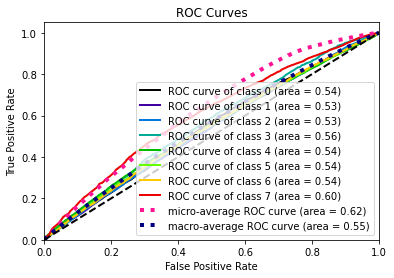

In [24]:
skplt.metrics.plot_roc(y_val, y_proba)

#### Classification Report

In [25]:
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.02      0.23      0.03       339
           1       0.44      0.18      0.26     14170
           2       0.24      0.18      0.21      7999
           3       0.00      0.00      0.00         4
           4       0.04      0.21      0.07       877
           5       0.00      0.15      0.01       119
           6       0.37      0.18      0.24     11187
           7       0.00      0.28      0.00        18

    accuracy                           0.18     34713
   macro avg       0.14      0.18      0.10     34713
weighted avg       0.36      0.18      0.23     34713



#### Feature Importance SHAP
Using SHAP values for feature importance

In [26]:
explainer_xgb = shap.TreeExplainer(xgbfit)
shap_values_xgb = explainer_xgb.shap_values(X_val)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


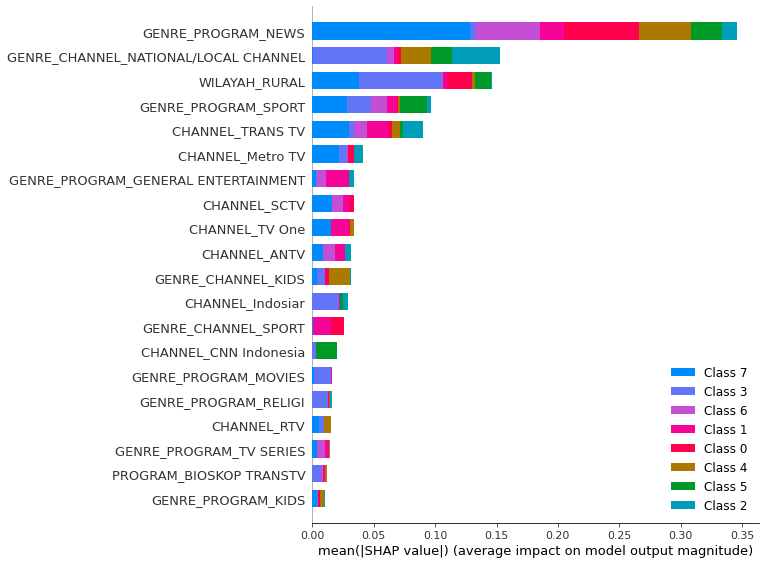

In [27]:
shap.summary_plot(shap_values_xgb, X_val, plot_type="bar")

## 4. Shapley Value for Symptomp Checking
1. Generate Shapley Value for every feature
2. nominate three feature with highest shaplue value for each row

In [131]:
shapley_df = pd.DataFrame(shap_values_xgb[1])
shapley_df.columns = X_val.columns
cols = shapley_df.columns

In [132]:
def get_n_largest_ind(a,n):
    ind = np.argpartition(a, -n)[-n:]
    return ind[0]

In [133]:
for n in [1,2,3]:
    shapley_df["VAR{}".format(n)] = shapley_df[cols].apply(lambda x: cols[get_n_largest_ind(x,n)],axis=1)

In [134]:
shapley_df

,PROGRAM_10 CLOVERFIELD LANE,PROGRAM_100 INDONESIA,PROGRAM_100 PERSENROMANTIS,PROGRAM_101 DALMATIAN STREET,PROGRAM_101 EAST: THE STUNTMEN OF BOLLYWOOD,PROGRAM_13 HOURS,PROGRAM_1920 LONDON,PROGRAM_2 FAST 2 FURIOUS,PROGRAM_2 WHEELS,PROGRAM_2019 PLAYOFF PLAYBACK RAPTORS VS. WARRIORS NBA FIN,PROGRAM_23 HARI CINTA MATEMATIKA,PROGRAM_24 JAM,PROGRAM_25 HARI MENGEJAR JODOH,PROGRAM_28 JAM MENUNGGU CINTA,PROGRAM_3 DAYS OF A BLIND GIRL,PROGRAM_3 MEALS A DAY- MOUNTAIN VILLAGE - EPS. 10,PROGRAM_3 MEALS A DAY- MOUNTAIN VILLAGE - EPS. 11,PROGRAM_3 MEALS A DAY- MOUNTAIN VILLAGE - EPS. 3,PROGRAM_3 MEALS A DAY- MOUNTAIN VILLAGE - EPS. 4,PROGRAM_3 MEALS A DAY- MOUNTAIN VILLAGE - EPS. 5,PROGRAM_3 MEALS A DAY- MOUNTAIN VILLAGE - EPS. 6,PROGRAM_3 MEALS A DAY- MOUNTAIN VILLAGE - EPS. 7,PROGRAM_3 MEALS A DAY- MOUNTAIN VILLAGE - EPS. 8,PROGRAM_3 MEALS A DAY- MOUNTAIN VILLAGE - EPS. 9,PROGRAM_3 NINJAS KNUCKLE UP,PROGRAM_3 SEMPRUL MENGEJAR SURGA 5,PROGRAM_3 SQUIRREL,PROGRAM_48 HRS DESTINATION,PROGRAM_5 RENCAH 5 RASA S18,PROGRAM_5-9 FROM FIVE TO NINE,PROGRAM_6 DAYS,PROGRAM_64 LE MONDE EN FRANCAIS - 2E PARTIE,PROGRAM_64 LE MONDE EN FRANCAIS - 1RE PARTIE,PROGRAM_6:30 2006,PROGRAM_7 PUSAKA: MINYAK SI NYONG NYONG,PROGRAM_86,PROGRAM_9 - 1 - 1 S2,PROGRAM_9 - 1 - 1 S3,PROGRAM_9-1-1 S2,PROGRAM_A BEAUTIFUL MIND,PROGRAM_A BETTER TOMORROW II,PROGRAM_A CURE FOR WELLNESS,PROGRAM_A DARK TRUTH,PROGRAM_A DISCOVERY OF WITCHES,PROGRAM_A DOG AND PONY SHOW,PROGRAM_A DREAMY JOURNEY,PROGRAM_A GOOD DAY TO DIE HARD,PROGRAM_A HARD DAY,PROGRAM_A HOUSE OF ITS TIME,PROGRAM_A MILITARY TRIBUTE TO THE GREENBRIER 2019,PROGRAM_A MILLION LITTLE THINGS S1,PROGRAM_A MILLION LITTLE THINGS S2,PROGRAM_A PERFECT DAY,PROGRAM_A PLACE IN THE SUN,PROGRAM_A SIMPLE FAVOR,PROGRAM_A STAR IS BORN,PROGRAM_A VIOLENT PROSECUTOR,PROGRAM_A WEREWOLF BOY,PROGRAM_AARON NEEDS A JOB S1,PROGRAM_ABB FIA FORMULA E CSHIP 201819 : SEASON REVIEW,PROGRAM_ABBY HATCHER S01,PROGRAM_ABU DHABI GS JIU JITSU WORLD TOUR 201819 - RIO,PROGRAM_ACCESS 360 WORLD HERITAGE,PROGRAM_ACROSS THE HALL,PROGRAM_ACROSS THE STRAIT,PROGRAM_ACTIVATE: THE GLOBAL CITIZEN MOVEMENT,PROGRAM_ADA CINTA DIBALIK BED COVER,PROGRAM_ADAM DAN HAWA,PROGRAM_ADVENTURE TIME,PROGRAM_ADZAN DLUHUR MUROTTAL,PROGRAM_ADZAN MAGHRIB MUROTTAL,PROGRAM_ADZAN SUBUH MUROTAL,PROGRAM_AEON FLUX,PROGRAM_AFC CHAMPIONS LEAGUE 2019,PROGRAM_AFC CUP 2019,PROGRAM_AFRICAS DEADLIEST COMPILATIONS,PROGRAM_AFRICAS DEADLY KINGDOM,PROGRAM_AFRICAS HUNTERS,PROGRAM_AFTER 10,PROGRAM_AFTER MIDNIGHT,PROGRAM_AFTER THE SUNSET,PROGRAM_AFTERNOON LIVE,PROGRAM_AGENT RAGHAV RR,PROGRAM_AIMAN,PROGRAM_AIR CRASH INVESTIGATION,PROGRAM_AIR DAN API,PROGRAM_AITRAAZ,PROGRAM_AKU DAN KAMU GAK MAU MUTUALAN GITU,PROGRAM_AKU DEKETIN KAMUKAMU DEEKETIN DIA,PROGRAM_AKU DINIKAHI HANYA UNTUK DICERAIKAN,PROGRAM_AKU HAMIL SUAMI BERPALING KE WANITA LAIN,PROGRAM_AKU ISTRI YANG DI DZOLIMI,PROGRAM_AKU MENANGIS TIAP MALAM KARENA TURUN RANJANG,PROGRAM_AKU MENDERITA KARENA CINTA YANG DIPAKSA,PROGRAM_AKU STM SUKA TAPI MALU NIH,PROGRAM_AKU TERLANJUR JATUH CINTA,PROGRAM_AL JAZEERA WORLD,PROGRAM_AL JAZEERA WORLD: ARABS ABROAD: THE POLITICIAN TH,PROGRAM_ALAM MEMUJI,PROGRAM_ALASKAS DEADLIEST,PROGRAM_ALIENS,PROGRAM_ALIENS VS. PREDATOR: REQUIEM,PROGRAM_ALL HAIL KING JULIEN,PROGRAM_ALL HAIL KING JULIEN: EXILED,PROGRAM_ALL OF MY HEART: INN LOVE,PROGRAM_ALL THE MONEY IN THE WORLD,PROGRAM_ALPEN ROSE,PROGRAM_ALVINNN AND THE CHIPMUNKS,PROGRAM_AMANPOUR,PROGRAM_AMAZING GRACE,PROGRAM_AMAZING TRIP,PROGRAM_AMERICAN DRAGON: JAKE LONG,PROGRAM_AMERICAN LEAGUE CHAMPIONSHIP SERIES 2019,PROGRAM_AMERICAN LEAGUE DIVISION SERIES 2019,PROGRAM_AMERICAN LEAGUE DIVISION SERIES 2019-,PROGRAM_AMERICAN LEAGUE WILD CARD 2019,PROGRAM_AMERICAN NINJA WARRIOR S8,PROGRAM_AMERICAN NINJA WARRIOR S9,PROGRAM_AMERICAN NINJA WARRIOR: NINJA VS. NINJA,PROGRAM_AMERICAS GOT TALENT S14,PROGRAM_AMERICAS NEXT TOP MODEL S24,PROGRAM_AMPHIBIA,PROGRAM_ANAK JALANAN SOPIR TAKSI CANTIK,PROGRAM_ANAK LANGIT,PROGRAM_ANAK MAGANG BIKIN SAYANG,PROGRAM_ANAK NINGRAT,PROGRAM_ANAK PEMBAWA BERKAH MENU

In [135]:
prob = xgbfit.predict_proba(X_val)[:,1]

In [136]:
shapley_df["PROBA"] = prob
shapley_df["PREDICTION"] = y_pred
shapley_df.columns = "SHAP_" + shapley_df.columns
df_final = df_train[df_train.index.isin(shapley_df.index)].join(shapley_df)

In [141]:
final_col = ['PROGRAM', 'WILAYAH', 'CHANNEL', 'GENRE_CHANNEL', 'GENRE_PROGRAM', 'SHAP_VAR1', 'SHAP_VAR2', 'SHAP_VAR3', 'SHAP_PROBA', 'SHAP_PREDICTION', 'AGE_GENDER']

In [142]:
df_final[final_col]

,PROGRAM,WILAYAH,CHANNEL,GENRE_CHANNEL,GENRE_PROGRAM,SHAP_VAR1,SHAP_VAR2,SHAP_VAR3,SHAP_PROBA,SHAP_PREDICTION,AGE_GENDER
0,10 CLOVERFIELD LANE,URBAN,Fox Movies,MOVIES,MOVIES,GENRE_PROGRAM_NEWS,PROGRAM_TAU GAK SIH,CHANNEL_TV One,0.171606,2,5
1,10 CLOVERFIELD LANE,RURAL,Fox Movies,MOVIES,MOVIES,GENRE_PROGRAM_TV SERIES,GENRE_PROGRAM_NEWS,CHANNEL_TV One,0.172931,1,4
2,10 CLOVERFIELD LANE,URBAN,Fox Movies,MOVIES,MOVIES,WILAYAH_RURAL,GENRE_CHANNEL_SPORT,GENRE_PROGRAM_SPORT,0.143240,6,6
3,10 CLOVERFIELD LANE,URBAN,Fox Movies,MOVIES,MOVIES,GENRE_PROGRAM_GENERAL ENTERTAINMENT,GENRE_PROGRAM_NEWS,CHANNEL_TV One,0.172598,1,1
4,10 CLOVERFIELD LANE,RURAL,Fox Movies,MOVIES,MOVIES,GENRE_PROGRAM_NEWS,CHANNEL_TV One,PROGRAM_UCL 2019 - 2020,0.126473,6,4
...,...,...,...,...,...,...,...,...,...,...,...
34708,GOLDEN MEMORIES ASIA TOP 24,URBAN,Indosiar,NATIONAL/LOCAL CHANNEL,MUSIC,CHANNEL_TV One,GENRE_CHANNEL_SPORT,GENRE_PROGRAM_SPORT,0.159767,6,2
34709,GOLDEN MEMORIES ASIA TOP 24,URBAN,Indosiar,NATIONAL/LOCAL CHANNEL,MUSIC,CHANNEL_TV One,GENRE_CHANNEL_SPORT,GENRE_PROGRAM_SPORT,0.156817,6,6
34710,GOLDEN MEMORIES ASIA TOP 24,RURAL,Indosiar,NATIONAL/LOCAL CHANNEL,MUSIC,GENRE_PROGRAM_GENERAL ENTERTAINMENT,GENRE_PROGRAM_NEWS,CHANNEL_TV One,0.174654,1,1
34711,GOLDEN MEMORIES ASIA TOP 24,RURAL,Indosiar,NATIONAL/LOCAL CHANNEL,MUSIC,CHANNEL_Disney Junior,GENRE_PROGRAM_NEWS,CHANNEL_TV One,0.169178,0,5
